Raw dataset: 50694 rows and 29 columns
Created date column from year, month, and day columns
Converted spend_retail_w_grocery from string to numeric
Converted spend_grf from string to numeric
Converted spend_sgh from string to numeric
Converted spend_durables from string to numeric
Converted spend_apg from string to numeric
Converted spend_inpersonmisc from string to numeric
Converted spend_remoteservices from string to numeric
Converted spend_all_q1 from string to numeric
Converted spend_all_q4 from string to numeric
Converted spend_all from string to numeric
Filled 1644 missing values in spend_retail_w_grocery
Filled 1644 missing values in spend_grf
Filled 1644 missing values in spend_sgh
Filled 1644 missing values in spend_durables
Filled 1644 missing values in spend_apg
Filled 1644 missing values in spend_inpersonmisc
Filled 1644 missing values in spend_remoteservices
Filled 4587 missing values in spend_all_q1
Filled 3606 missing values in spend_all_q4
Recovery dataset: 31977 rows 

<Figure size 1400x800 with 0 Axes>

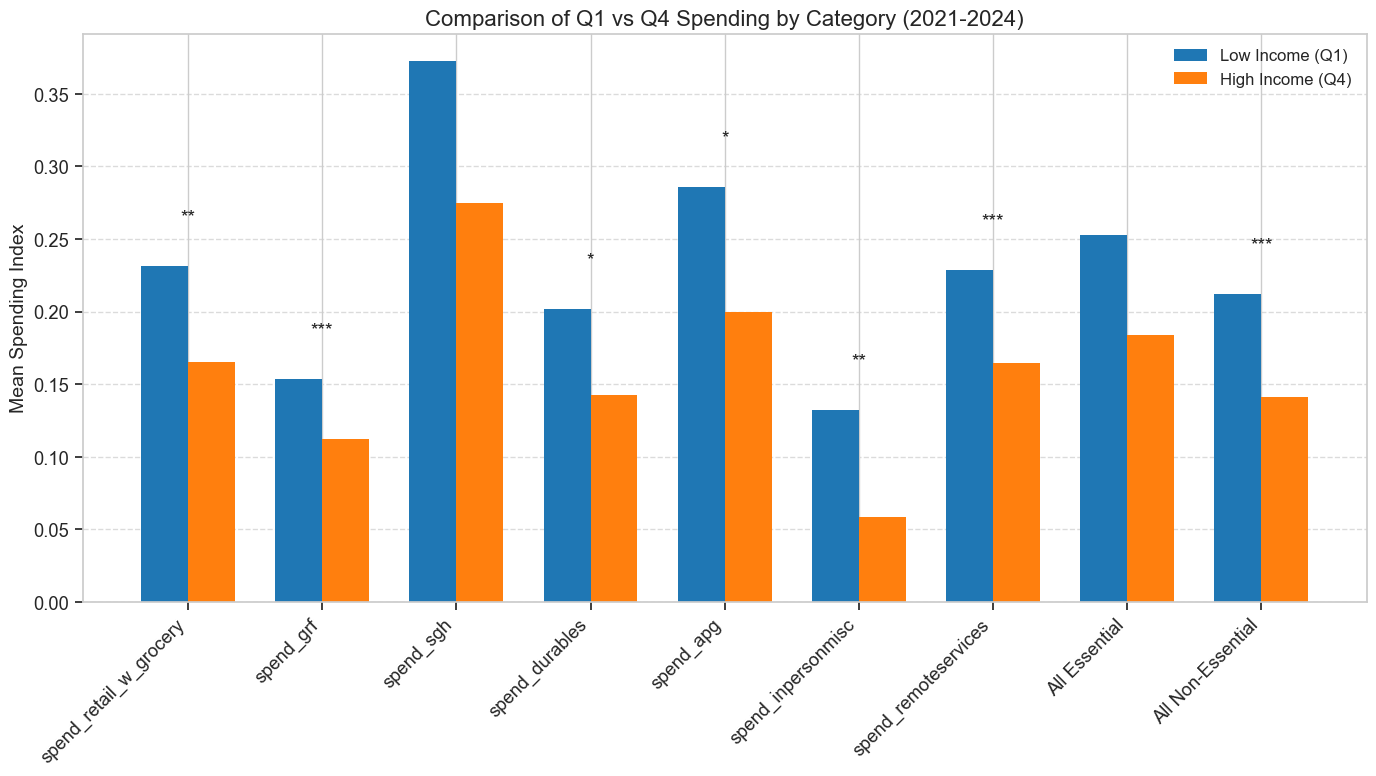

<Figure size 1000x600 with 0 Axes>

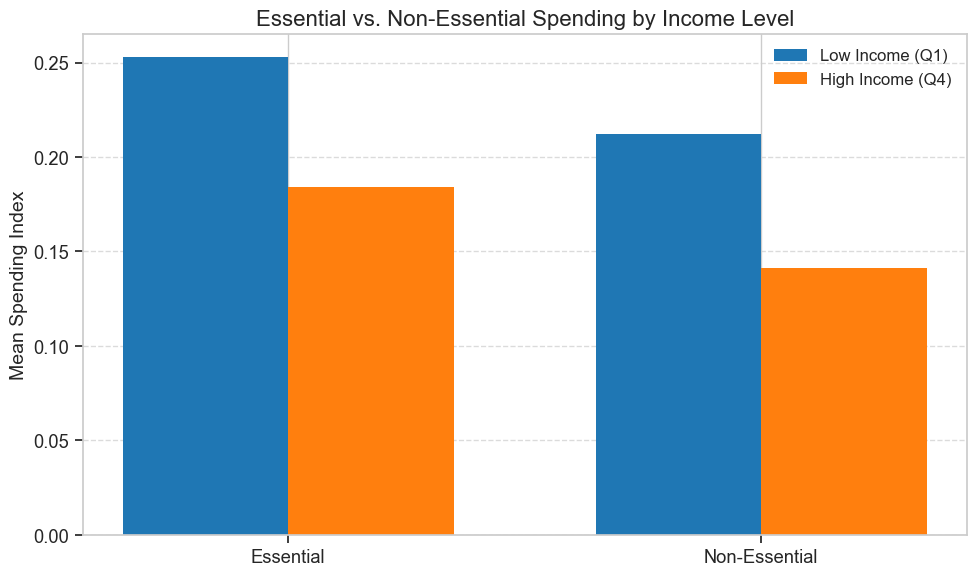

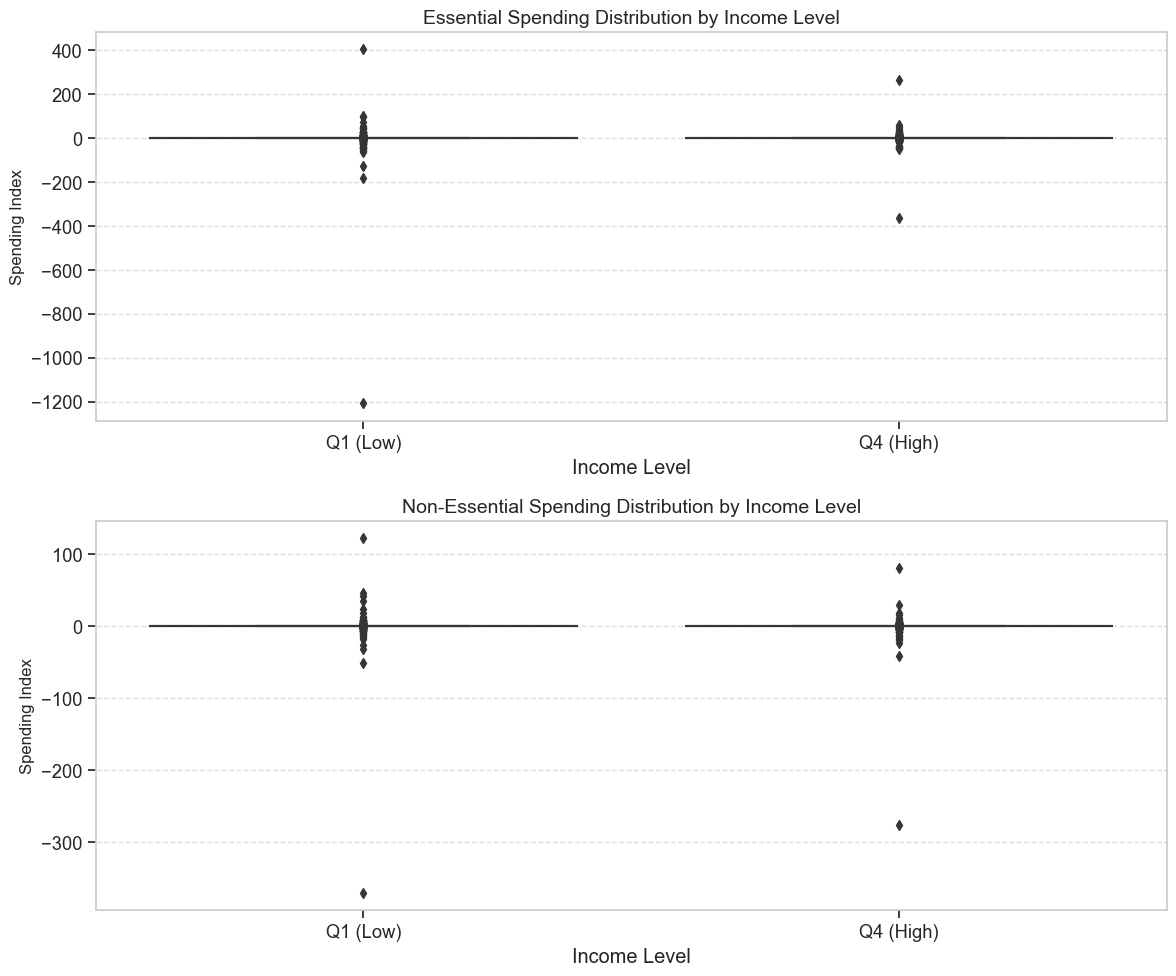


Preparing analysis summary...

Summary Table (Sorted by Difference Magnitude):
                 Category           Type  Q1 Mean  Q4 Mean  Difference  \
2               spend_sgh      Essential   0.3728   0.2748      0.0980   
4               spend_apg  Non-Essential   0.2861   0.2000      0.0861   
5      spend_inpersonmisc  Non-Essential   0.1323   0.0588      0.0736   
8       All Non-Essential  Non-Essential   0.2122   0.1415      0.0707   
7           All Essential      Essential   0.2527   0.1840      0.0686   
0  spend_retail_w_grocery      Essential   0.2315   0.1651      0.0663   
6    spend_remoteservices  Non-Essential   0.2286   0.1648      0.0637   
3          spend_durables  Non-Essential   0.2018   0.1423      0.0595   
1               spend_grf      Essential   0.1537   0.1121      0.0416   

   CI_Lower  CI_Upper  t-test p-value  Cohen's d Effect Size  
2   -0.1292    0.2694         0.34641      0.008  Negligible  
4   -0.0090    0.1604         0.03651      0.017  Neg

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set aesthetic parameters for plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
sns.set_context("notebook", font_scale=1.2)

# Load the dataset
df = pd.read_excel("D:/capstone/datasets/Affinity - State - Daily.xlsx")
print(f"Raw dataset: {df.shape[0]} rows and {df.shape[1]} columns")

# Create date column if it doesn't exist
if 'date' not in df.columns:
    if all(col in df.columns for col in ['year', 'month', 'day']):
        df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
        print("Created date column from year, month, and day columns")

# Define spending categories
essential_categories = ['spend_retail_w_grocery', 'spend_grf', 'spend_sgh']
non_essential_categories = ['spend_durables', 'spend_apg', 'spend_inpersonmisc', 'spend_remoteservices']
income_columns = ['spend_all_q1', 'spend_all_q4']

# Convert string values to numeric for ALL relevant columns
all_columns_to_convert = essential_categories + non_essential_categories + income_columns + ['spend_all']
for col in all_columns_to_convert:
    if col in df.columns:
        # Check if column contains string values
        if df[col].dtype == 'object':
            df[col] = pd.to_numeric(df[col], errors='coerce')
            print(f"Converted {col} from string to numeric")
        # Force numeric conversion even for mixed types
        else:
            orig_type = df[col].dtype
            df[col] = pd.to_numeric(df[col], errors='coerce')
            if orig_type != df[col].dtype:
                print(f"Forced {col} to numeric from {orig_type}")

# Handle missing values
for col in essential_categories + non_essential_categories + income_columns:
    if col in df.columns and df[col].isna().sum() > 0:
        missing_count = df[col].isna().sum()
        df[col] = df[col].fillna(df[col].median())
        print(f"Filled {missing_count} missing values in {col}")

# Filter for recovery phase
df_recovery = df[df['date'] >= '2021-01-01'].copy()
print(f"Recovery dataset: {len(df_recovery)} rows from {df_recovery['date'].min().strftime('%Y-%m-%d')} to {df_recovery['date'].max().strftime('%Y-%m-%d')}")

# ----- COMPUTING CATEGORY-LEVEL SPENDING BY INCOME QUARTILE -----
print("\nComputing category-level spending by income quartile...")

# Create the derived columns for each category by income level
print("Creating derived category-level income quartile columns...")
for category in essential_categories + non_essential_categories:
    # Handle potential division by zero or null values
    denominator = df_recovery['spend_all'].replace(0, np.nan)
    
    # Create derived columns with safer calculation
    df_recovery[f"{category}_q1"] = (df_recovery[category] * df_recovery['spend_all_q1']).div(denominator)
    df_recovery[f"{category}_q4"] = (df_recovery[category] * df_recovery['spend_all_q4']).div(denominator)
    
    # Check for anomalies in the derived columns
    q1_nans = df_recovery[f"{category}_q1"].isna().sum()
    q4_nans = df_recovery[f"{category}_q4"].isna().sum()
    if q1_nans > 0 or q4_nans > 0:
        print(f"  Warning: {category} has {q1_nans} NaNs in Q1 and {q4_nans} NaNs in Q4")

# Calculate aggregated essential and non-essential spending
print("Calculating aggregated metrics...")

# Check for data quality first
for cat_type, categories in [("Essential", essential_categories), ("Non-Essential", non_essential_categories)]:
    for cat in categories:
        # Check extreme values
        for q in ['q1', 'q4']:
            col = f"{cat}_{q}"
            if df_recovery[col].max() > 100:  # Arbitrary threshold for anomaly detection
                print(f"  Warning: {col} has max value of {df_recovery[col].max()}, which seems high")

# Now calculate aggregates
df_recovery['essential_q1'] = df_recovery[[f"{cat}_q1" for cat in essential_categories]].mean(axis=1)
df_recovery['essential_q4'] = df_recovery[[f"{cat}_q4" for cat in essential_categories]].mean(axis=1)
df_recovery['non_essential_q1'] = df_recovery[[f"{cat}_q1" for cat in non_essential_categories]].mean(axis=1)
df_recovery['non_essential_q4'] = df_recovery[[f"{cat}_q4" for cat in non_essential_categories]].mean(axis=1)

# Report the aggregated metrics
print(f"  Essential Q1 mean: {df_recovery['essential_q1'].mean():.4f}")
print(f"  Essential Q4 mean: {df_recovery['essential_q4'].mean():.4f}")
print(f"  Non-Essential Q1 mean: {df_recovery['non_essential_q1'].mean():.4f}")
print(f"  Non-Essential Q4 mean: {df_recovery['non_essential_q4'].mean():.4f}")

# ----- DATA ANALYSIS FOR INCOME LEVELS AND CATEGORIES -----
print("\nAnalyzing spending by income level and category...")

# Create a results dataframe to store all statistical comparisons
results = []

# Function to run statistical tests
def run_tests(q1_data, q4_data, category_name, category_type):
    # Drop NaN values before analysis
    q1_clean = q1_data.dropna()
    q4_clean = q4_data.dropna()
    
    # Check if we have enough data to perform tests
    if len(q1_clean) < 10 or len(q4_clean) < 10:
        print(f"  Warning: Limited data for {category_name} - Q1: {len(q1_clean)} samples, Q4: {len(q4_clean)} samples")
    
    # Calculate basic stats
    q1_mean = q1_clean.mean()
    q4_mean = q4_clean.mean()
    difference = q1_mean - q4_mean
    percent_diff = (difference / q4_mean) * 100 if q4_mean != 0 else np.nan
    
    # Check for normality to determine appropriate tests
    # (Shapiro-Wilk test is good for smaller datasets)
    q1_normal = True
    q4_normal = True
    if len(q1_clean) >= 3 and len(q1_clean) <= 5000:  # Shapiro-Wilk has sample size limitations
        try:
            _, q1_p = stats.shapiro(q1_clean)
            q1_normal = q1_p > 0.05
        except:
            q1_normal = True  # Default to parametric if test fails
            
    if len(q4_clean) >= 3 and len(q4_clean) <= 5000:
        try:
            _, q4_p = stats.shapiro(q4_clean)
            q4_normal = q4_p > 0.05
        except:
            q4_normal = True  # Default to parametric if test fails
    
    # T-test (parametric) or Mann-Whitney U test (non-parametric) based on normality
    if q1_normal and q4_normal:
        t_stat, p_value = stats.ttest_ind(q1_clean, q4_clean, equal_var=False)  # Welch's t-test (doesn't assume equal variance)
    else:
        t_stat, p_value = stats.mannwhitneyu(q1_clean, q4_clean)
        
    # Wilcoxon signed-rank test (for paired samples)
    # Note: This is typically used for paired data, which might not be applicable here
    # unless the same entities are measured at both income levels
    try:
        # For demonstration only - the actual data might not be paired
        min_len = min(len(q1_clean), len(q4_clean))
        w_stat, w_p_value = stats.wilcoxon(q1_clean[:min_len], q4_clean[:min_len])
    except:
        w_stat, w_p_value = np.nan, np.nan
    
    # Effect size (Cohen's d) - more robust calculation
    # Calculate using pooled standard deviation with sample size weights
    n1, n4 = len(q1_clean), len(q4_clean)
    if n1 > 0 and n4 > 0:  # Avoid division by zero
        s1, s4 = q1_clean.std(), q4_clean.std()
        # Weighted pooled SD formula
        pooled_std = np.sqrt(((n1-1)*(s1**2) + (n4-1)*(s4**2)) / (n1+n4-2))
        cohens_d = difference / pooled_std if pooled_std != 0 else np.nan
    else:
        cohens_d = np.nan
    
    # Effect size interpretation
    if abs(cohens_d) < 0.2:
        effect_size = "Negligible"
    elif abs(cohens_d) < 0.5:
        effect_size = "Small"
    elif abs(cohens_d) < 0.8:
        effect_size = "Medium"
    else:
        effect_size = "Large"
    
    # Store results
    result = {
        "Category": category_name,
        "Type": category_type,
        "Q1 Mean": q1_mean,
        "Q4 Mean": q4_mean,
        "Difference": difference,
        "Percent Difference": percent_diff,
        "t-statistic": t_stat,
        "t-test p-value": p_value,
        "Wilcoxon statistic": w_stat,
        "Wilcoxon p-value": w_p_value,
        "Cohen's d": cohens_d,
        "Effect Size": effect_size,
        "Higher Spending": "Q1" if q1_mean > q4_mean else "Q4"
    }
    
    return result

# Process categories
all_categories = []
for category_name in essential_categories:
    all_categories.append({"name": category_name, "type": "Essential"})
for category_name in non_essential_categories:
    all_categories.append({"name": category_name, "type": "Non-Essential"})

# Add aggregated categories
all_categories.append({"name": "All Essential", "type": "Essential"})
all_categories.append({"name": "All Non-Essential", "type": "Non-Essential"})

# Analyze individual categories
print("\nAnalyzing individual categories...")
for category in all_categories:
    category_name = category["name"]
    category_type = category["type"]
    
    if category_name == "All Essential":
        q1_data = df_recovery['essential_q1']
        q4_data = df_recovery['essential_q4']
    elif category_name == "All Non-Essential":
        q1_data = df_recovery['non_essential_q1']
        q4_data = df_recovery['non_essential_q4']
    else:
        q1_data = df_recovery[f"{category_name}_q1"]
        q4_data = df_recovery[f"{category_name}_q4"]
    
    # Print progress
    print(f"  Testing {category_type}: {category_name}")
    
    # Catch any exceptions to make the analysis more robust
    try:
        result = run_tests(q1_data, q4_data, category_name, category_type)
        results.append(result)
    except Exception as e:
        print(f"  Error analyzing {category_name}: {str(e)}")
        # Add a placeholder result with error message
        results.append({
            "Category": category_name,
            "Type": category_type,
            "Q1 Mean": q1_data.mean(),
            "Q4 Mean": q4_data.mean(),
            "Difference": q1_data.mean() - q4_data.mean(),
            "Percent Difference": np.nan,
            "t-statistic": np.nan,
            "t-test p-value": np.nan,
            "Wilcoxon statistic": np.nan,
            "Wilcoxon p-value": np.nan,
            "Cohen's d": np.nan,
            "Effect Size": "Error",
            "Higher Spending": "Q1" if q1_data.mean() > q4_data.mean() else "Q4",
            "Error": str(e)
        })

# Convert results to DataFrame for easier analysis
results_df = pd.DataFrame(results)
print("\nStatistical comparison results:")
print(results_df[['Category', 'Type', 'Q1 Mean', 'Q4 Mean', 'Difference', 't-test p-value', 'Cohen\'s d', 'Effect Size']])

# ----- VISUALIZATIONS -----
print("\nCreating visualizations...")

# 1. Bar chart comparing Q1 vs Q4 for each category
plt.figure(figsize=(14, 8))
categories = results_df['Category'].tolist()
q1_means = results_df['Q1 Mean'].tolist()
q4_means = results_df['Q4 Mean'].tolist()
x = np.arange(len(categories))
width = 0.35

fig, ax = plt.subplots(figsize=(14, 8))
rects1 = ax.bar(x - width/2, q1_means, width, label='Low Income (Q1)', color='#1f77b4')
rects2 = ax.bar(x + width/2, q4_means, width, label='High Income (Q4)', color='#ff7f0e')

# Add category labels and styling
ax.set_ylabel('Mean Spending Index', fontsize=14)
ax.set_title('Comparison of Q1 vs Q4 Spending by Category (2021-2024)', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(categories, rotation=45, ha='right')
ax.legend(fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Add significance asterisks
for i, p_value in enumerate(results_df['t-test p-value']):
    significance = ""
    if p_value < 0.001:
        significance = "***"
    elif p_value < 0.01:
        significance = "**"
    elif p_value < 0.05:
        significance = "*"
    
    if significance:
        higher = max(q1_means[i], q4_means[i])
        ax.text(i, higher + 0.03, significance, ha='center', fontsize=14)

plt.tight_layout()
plt.savefig('income_category_comparison.png', dpi=300)
plt.show()

# 2. Bar chart for aggregated essential vs non-essential by income
plt.figure(figsize=(10, 6))
# Filter for just the aggregated categories
agg_data = results_df[results_df['Category'].isin(['All Essential', 'All Non-Essential'])]
categories = agg_data['Category'].tolist()
q1_means = agg_data['Q1 Mean'].tolist()
q4_means = agg_data['Q4 Mean'].tolist()
x = np.arange(len(categories))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, q1_means, width, label='Low Income (Q1)', color='#1f77b4')
rects2 = ax.bar(x + width/2, q4_means, width, label='High Income (Q4)', color='#ff7f0e')

ax.set_ylabel('Mean Spending Index', fontsize=14)
ax.set_title('Essential vs. Non-Essential Spending by Income Level', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels([c.replace('All ', '') for c in categories])
ax.legend(fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('essential_nonessential_by_income.png', dpi=300)
plt.show()

# 3. Boxplots for distribution comparison (essential vs non-essential by income)
plt.figure(figsize=(12, 10))

# Create box plots with split by income level
plt.subplot(2, 1, 1)
sns.boxplot(data=pd.melt(
    df_recovery[['essential_q1', 'essential_q4']],
    var_name='Income Level',
    value_name='Spending'
).replace({'essential_q1': 'Q1 (Low)', 'essential_q4': 'Q4 (High)'}),
    x='Income Level', y='Spending'
)
plt.title('Essential Spending Distribution by Income Level', fontsize=14)
plt.ylabel('Spending Index', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.subplot(2, 1, 2)
sns.boxplot(data=pd.melt(
    df_recovery[['non_essential_q1', 'non_essential_q4']],
    var_name='Income Level',
    value_name='Spending'
).replace({'non_essential_q1': 'Q1 (Low)', 'non_essential_q4': 'Q4 (High)'}),
    x='Income Level', y='Spending'
)
plt.title('Non-Essential Spending Distribution by Income Level', fontsize=14)
plt.ylabel('Spending Index', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('spending_distribution_boxplots.png', dpi=300)
plt.show()

# ----- ANALYSIS SUMMARY -----
print("\nPreparing analysis summary...")

# Handle potential errors in the results DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.replace([np.inf, -np.inf], np.nan)

# Add 95% confidence intervals for more rigorous analysis
results_df['CI_Lower'] = np.nan
results_df['CI_Upper'] = np.nan

for idx, row in results_df.iterrows():
    category = row['Category']
    try:
        # Calculate 95% CI for the difference in means
        q1_data = df_recovery[f"{category}_q1" if category not in ["All Essential", "All Non-Essential"] 
                            else 'essential_q1' if category == "All Essential" 
                            else 'non_essential_q1']
        q4_data = df_recovery[f"{category}_q4" if category not in ["All Essential", "All Non-Essential"]
                            else 'essential_q4' if category == "All Essential"
                            else 'non_essential_q4']
        
        # Bootstrap confidence interval for the difference in means
        n_boot = 1000
        boot_diffs = []
        
        for _ in range(n_boot):
            q1_sample = q1_data.dropna().sample(frac=1, replace=True)
            q4_sample = q4_data.dropna().sample(frac=1, replace=True)
            boot_diffs.append(q1_sample.mean() - q4_sample.mean())
            
        ci_lower = np.percentile(boot_diffs, 2.5)
        ci_upper = np.percentile(boot_diffs, 97.5)
        
        results_df.loc[idx, 'CI_Lower'] = ci_lower
        results_df.loc[idx, 'CI_Upper'] = ci_upper
    except:
        # Skip if calculation fails
        pass

# Create summary table sorted by absolute difference
summary_table = results_df.sort_values(by='Difference', key=abs, ascending=False)
summary_table = summary_table[['Category', 'Type', 'Q1 Mean', 'Q4 Mean', 'Difference', 'CI_Lower', 'CI_Upper', 't-test p-value', 'Cohen\'s d', 'Effect Size']]
summary_table = summary_table.round({
    'Q1 Mean': 4,
    'Q4 Mean': 4,
    'Difference': 4,
    'CI_Lower': 4,
    'CI_Upper': 4,
    't-test p-value': 5,
    'Cohen\'s d': 3
})

print("\nSummary Table (Sorted by Difference Magnitude):")
print(summary_table)

# Count significant differences with Bonferroni correction
alpha = 0.05
alpha_corrected = alpha / results_df.shape[0]  # Bonferroni correction
sig_diffs = results_df[results_df['t-test p-value'] < alpha].shape[0]
sig_diffs_corrected = results_df[results_df['t-test p-value'] < alpha_corrected].shape[0]
total_cats = results_df.shape[0]

# Determine predominant spending pattern
q1_higher_count = results_df[results_df['Higher Spending'] == 'Q1'].shape[0]
q4_higher_count = results_df[results_df['Higher Spending'] == 'Q4'].shape[0]

# Check if CI includes zero (indicates non-significant difference)
results_df['CI_Includes_Zero'] = (results_df['CI_Lower'] <= 0) & (results_df['CI_Upper'] >= 0)
non_zero_ci_count = results_df[~results_df['CI_Includes_Zero']].shape[0]

# Save both a CSV file and an Excel file for compatibility
summary_table.to_csv('income_spending_analysis_results.csv', index=False)
summary_table.to_excel('income_spending_analysis_results.xlsx', index=False)
print("\nAnalysis complete. Results saved to CSV and Excel files.")

print("\nKey findings:")
print(f"1. {sig_diffs} out of {total_cats} categories show statistically significant differences (p < 0.05)")
print(f"   - With Bonferroni correction (p < {alpha_corrected:.5f}): {sig_diffs_corrected} significant categories")
print(f"   - Based on 95% CI not including zero: {non_zero_ci_count} significant categories")
print(f"2. Low income (Q1) spends more in {q1_higher_count} categories, High income (Q4) spends more in {q4_higher_count} categories")

# Find categories with largest differences
try:
    max_pos_diff = results_df.loc[results_df['Difference'].idxmax()]
    max_neg_diff = results_df.loc[results_df['Difference'].idxmin()]
    print(f"3. Category with largest positive difference (Q1 > Q4): {max_pos_diff['Category']} ({max_pos_diff['Difference']:.4f})")
    print(f"4. Category with largest negative difference (Q4 > Q1): {max_neg_diff['Category']} ({max_neg_diff['Difference']:.4f})")
except:
    print("3. Could not determine categories with largest differences")

# Effect size distribution
print("5. Effect size distribution:")
for effect in ['Large', 'Medium', 'Small', 'Negligible', 'Error']:
    count = results_df[results_df['Effect Size'] == effect].shape[0]
    if count > 0:
        print(f"   - {effect}: {count} categories")